In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 16 19:08:43 2019
Revised on 2023/04/02
 
@author: mjofre
"""
###############################################################################
# Scripts to assess the secure key rate of DV-QKD and CV-QKD
# There might be commercial solutions available, such as: https://www.vpiphotonics.com/Tools/QKD/
###############################################################################

import os, sys
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')


In [2]:
def TransmissionBB84DecoyStateComputeSKRcontinuousphase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,SystemDetectorPerformanceArray,DVQKDprotocol):
    # H.-K. Lo, X. Ma, and K. Chen, “Decoy State Quantum Key Distribution,” Phys. Rev. Lett., vol. 94, no. 23, p. 230504, Jun. 2005, doi: 10.1103/PhysRevLett.94.230504.
    
    RateAlice=SourcePulseRate
    Nlen=len(AttenuationdBforDistance)
    alphaLink=SystemDetectorPerformanceArray[5] # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0
    #Distance_plot=Distance*1e-3
    
    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]

    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    Mu=DecoyStatesPhotPulse[0]#0.5
    Nu1=DecoyStatesPhotPulse[1]#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]#Mu*np.power(10,(-14.76/10.0))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    
    RateOutputAlice_signal=RateAlice*Mu # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states
    
    # Yield of a i-photon pulse
    Y1 = Y0+(1-(1-att)**1)
    Y2 = Y0+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0

    edetector=0#1.0-cos(atan(0.05))**2#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
        
    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield.
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of single photon pulses
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound = Y2# approx #(np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q0LowerBound = Mu*np.exp(-Mu)*Y0LowerBound # Gain of the vacuum-photon pulses.    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses. # # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)

    e0Bound=e0*np.ones((int(len(Y0LowerBound))),dtype=np.float32)
    e1UpperBound = (EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu)) # Error rate of single photon pulses
    e2UpperBound = (EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon. In general the bit error ratio of n-photon signals being e_n=Y_0/(2*Y_n)
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    if (np.sum(KeyBitRateLowerBond<0.0)>0):
        KeyBitRateLowerBond[KeyBitRateLowerBond<0.0]=0.0
        
    # Remove glitches
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
        
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def TransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,Nphases,SystemDetectorPerformanceArray,DVQKDprotocol):
    Nphases=int(np.min([16,np.max([1.0,Nphases])]))
    NphasesValue=np.linspace(0,2*np.pi,Nphases) # Nphases different values each with probability 1/Nphases over [0, 2*np.pi)]
    Nlen=len(AttenuationdBforDistance)
    RateAlice=SourcePulseRate
    alphaLink=SystemDetectorPerformanceArray[5] # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3

    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]
    
    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    Mu=DecoyStatesPhotPulse[0]#0.5
    Nu1=DecoyStatesPhotPulse[1]#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]#Mu*np.power(10,(-14.76/10.0))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    
    RateOutputAlice_signal=RateAlice*Mu # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states
    
    # Yield of a i-photon pulse
    Y1 = Y0+(1-(1-att)**1)
    Y2 = Y0+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0    
    
    edetector=0#1.0-cos(atan(0.05))**2#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
        
    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    #############################################################################
    # Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    # https://iopscience.iop.org/article/10.1088/1367-2630/17/5/053014/pdf
    # Parameters that deviate in the decoy-state protocol from discrete phase are Y and e
    NiIterInfApprox=11 # Simulation number of iterations. The larger the better before saturating the computer
    
    P0=0.0 # A probability
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P0=P0+float(((np.power(Mu,iIterInfApprox*Nphases+0)*np.exp(-Mu))/(np.math.factorial(iIterInfApprox*Nphases+0))))
    
    if (P0<0.0):
        P0=0.0
    
    if (P0>1.0):
        P0=1.0
    
    P1=0.0 # A probability
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P1=P1+float(((np.power(Mu,iIterInfApprox*Nphases+1)*np.exp(-Mu))/(np.math.factorial(iIterInfApprox*Nphases+1))))
    
    if (P1<0.0):
        P1=0.0
    
    if (P1>1.0):
        P1=1.0
    
    F0=0.0 # Fidelity (between 0 and 1)
    F0numerator=0.0
    F0denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F0numerator=F0numerator+float(((np.power(Mu,iIterInfApprox*Nphases+0))/(np.math.factorial(iIterInfApprox*Nphases+0)))*(np.power(2.0,-(iIterInfApprox*Nphases+0)/2.0))*(np.cos((iIterInfApprox*Nphases+0)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+0)*np.pi/4.0)))
        F0denominator=F0denominator+float((np.power(Mu,iIterInfApprox*Nphases+0))/np.math.factorial(iIterInfApprox*Nphases+0))
    
    F0=float(F0numerator/F0denominator)
    
    if (F0<0.0):
        F0=0.0
    
    if (F0>1.0):
        F0=1.0
    
    F1=0.0 # Fidelity (between 0 and 1)
    F1numerator=0.0
    F1denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F1numerator=F1numerator+float(((np.power(Mu,iIterInfApprox*Nphases+1))/(np.math.factorial(iIterInfApprox*Nphases+1)))*(np.power(2.0,-(iIterInfApprox*Nphases+1)/2.0))*(np.cos((iIterInfApprox*Nphases+1)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+1)*np.pi/4.0)))
        F1denominator=F1denominator+float((np.power(Mu,iIterInfApprox*Nphases+1))/np.math.factorial(iIterInfApprox*Nphases+1))
    
    F1=float(F1numerator/F1denominator)
    
    if (F1<0.0):
        F1=0.0
    
    if (F1>1.0):
        F1=1.0
    
    F2=0.0 # Fidelity (between 0 and 1)
    F2numerator=0.0
    F2denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F2numerator=F2numerator+float(((np.power(Mu,iIterInfApprox*Nphases+2))/(np.math.factorial(iIterInfApprox*Nphases+2)))*(np.power(2.0,-(iIterInfApprox*Nphases+2)/2.0))*(np.cos((iIterInfApprox*Nphases+2)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+2)*np.pi/4.0)))
        F2denominator=F2denominator+float((np.power(Mu,iIterInfApprox*Nphases+2))/np.math.factorial(iIterInfApprox*Nphases+2))
    
    F2=float(F2numerator/F2denominator)
    
    if (F2<0.0):
        F2=0.0
    
    if (F2>1.0):
        F2=1.0
    
    Y0LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield. Changed for N-phase
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield. Changed for N-phase
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y2LowerBound = Y2# approx # (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses.

    Delta0=np.zeros((int(Nlen)),dtype=np.float32)
    if (np.sum(Y0LowerBound<=0.0)>1):
      Delta0[Y0LowerBound>0.0]=(1.0-F0)/(2.0*Y0LowerBound[Y0LowerBound>0.0])
      Delta0[Y0LowerBound<=0.0]=0.0
    else:
      Delta0=(1.0-F0)/(2.0*Y0LowerBound)
    
    Delta0aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta0aux=Delta0*(1.0-Delta0)*e0*(1.0-e0)
    if (np.sum(Delta0aux<0.0)>0):
        Delta0aux[Delta0aux<0.0]=0.0
    
    e0Bound=e0*np.ones_like(Delta0)#+4.0*Delta0*(1.0-Delta0)*(1.0-2.0*e0)+4.0*(1.0-2.0*Delta0)*np.sqrt(Delta0aux) # Changed for N-phase
    
    #print('e0Bound: '+str(e0Bound))
    
    if (np.sum(e0Bound<0.0)>0):
        e0Bound[e0Bound<0.0]=0.0
    
    if (np.sum(e0Bound>1.0)>0):
        e0Bound[e0Bound>1.0]=1.0
        
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F1)/(2.0*Y1LowerBound)   
    
    e1=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu))
    e1=np.abs(e1)
    if (np.sum(e1<0.0)>0):
        e1[e1<0.0]=0.0
    
    if (np.sum(e1>1.0)>0):
        e1[e1>1.0]=1.0
    
    #print('e1: '+str(e1))    
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e1*(1.0-e1)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e1UpperBound = e1+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e1)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    #print('e1UpperBound: '+str(e1UpperBound))    
    
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F2)/(2.0*Y2LowerBound)

    e2=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    e2=np.abs(e2)
    if (np.sum(e2<0.0)>0):
        e2[e2<0.0]=0.0
    
    if (np.sum(e2>1.0)>0):
        e2[e2>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e2*(1.0-e2)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e2UpperBound = e2+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e2)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0    
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    ## Remove glitches    
    if (np.sum(np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0)))>0):
        KeyBitRateLowerBond[np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0))]=0.0
        
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
    
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def PrecisionElementsTransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,SinglePhotonSourceAttdB,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,ConfigurationLaserSource,ConfigurationPulseShaping,ConfigurationPhases,ConfigurationPolarizationSelection,ConfigurationSPlevelAtt,SystemDetectorPerformanceArray,DVQKDprotocol):
    # Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    DeltaPhaseDeviation=float(ConfigurationPhases[1]*2.0*np.pi)
    Nphases=int(np.min([16,np.max([1.0,ConfigurationPhases[0]])]))
    AmplitudeDeviationPulseShape=np.max([0.0,np.min([1.0,ConfigurationPulseShaping[0]])])
    AmplitudeVariationPulseShape=np.max([0.0,np.min([1.0,ConfigurationPulseShaping[1]])])
    AmplitudeDeviationPulsePickUp=np.max([0.0,np.min([1.0,ConfigurationPolarizationSelection[0]])]) # Quality of the PER
    AmplitudeVariationPulsePickUp=np.max([0.0,np.min([1.0,ConfigurationPolarizationSelection[1]])])
    PowerDeviationPulseSPatt=np.max([0.0,np.min([1.0,ConfigurationSPlevelAtt[0]])])
    PowerVariationPulseSPatt=np.max([0.0,np.min([1.0,ConfigurationSPlevelAtt[1]])])
    PowerDeviationLaser=np.max([0.0,np.min([1.0,ConfigurationLaserSource[0]])])
    PowerVariationLaser=np.max([0.0,np.min([1.0,ConfigurationLaserSource[1]])])

    Y0=SystemDetectorPerformanceArray[0]
    e0=SystemDetectorPerformanceArray[1]
    transmittanceBob=SystemDetectorPerformanceArray[2]
    attDetectors=SystemDetectorPerformanceArray[3]
    TimeJitterStd=SystemDetectorPerformanceArray[4]
    
    Nlen=len(AttenuationdBforDistance)
    RateAlice=SourcePulseRate
    alphaLink=SystemDetectorPerformanceArray[5] # 0.1 dB/Km link loss free-space attenuation # 0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3
    
    MuRate=DecoyStatesRates[0] # Rate of signal states sent
    Nu1Rate=DecoyStatesRates[1] # Rate of decoy 1 states sent
    Nu2Rate=DecoyStatesRates[2] # Rate of decoy 2 states sent
    
    if ((MuRate+Nu1Rate+Nu2Rate)!=1.0):
        print('MuRate+Nu1Rate+Nu2Rate: '+str(MuRate+Nu1Rate+Nu2Rate))
        print('Error in the settings rates of the signal and decoy rates (MuRate+Nu1Rate+Nu2Rate)!=1.0')
        return
    
    fe=1.16 # bidirectional error correction factor
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob

    Mu=DecoyStatesPhotPulse[0]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#0.5
    Nu1=DecoyStatesPhotPulse[1]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#Mu*np.power(10,(-4.65/10.0))
    Nu2=DecoyStatesPhotPulse[2]*(1.0+AmplitudeDeviationPulseShape)*(1.0+PowerDeviationLaser)*(1.0+PowerDeviationPulseSPatt)#Mu*np.power(10,(-14.76/10.0))

    if (TimeJitterStd<=0.0):
      ERFCjitter=0.0
    else:
      ERFCjitter=math.erfc((1.0/SourcePulseRate)/TimeJitterStd)
    
    Y0plusTimeJitter=Y0+ERFCjitter*np.exp(-att*Mu)

    # Yield of a i-photon pulse
    Y1 = Y0plusTimeJitter+(1-(1-att)**1)
    Y2 = Y0plusTimeJitter+(1-(1-att)**2)
    
    # Fung, C.-H.F., Tamaki, K., Lo, H.-K.: Performance of two quantum-key-distribution protocols. Phys. Rev. A 73(1), 012337 (2006)
    # Ma, X., Qi, B., Zhao, Y., Lo, H.-K.: Practical decoy state for quantum key distribution. Phys. Rev. A 72(1), 012326 (2005)
    # Gain of states
    QMu = Y0plusTimeJitter+1-np.exp(-att*Mu) # Gain of the signal state. Equivalent to Y0 if Mu=0
    QNu1 = Y0plusTimeJitter+1-np.exp(-att*Nu1) # Gain of the decoy state. Equivalent to Y0 if Nu1=0
    QNu2 = Y0plusTimeJitter+1-np.exp(-att*Nu2) # Gain of the vacuum state. Equivalent to Y0 if Nu2=0

    if (AmplitudeVariationPulsePickUp<=0.0):
      ERFCcodingState=0.0
    else:
      ERFCcodingState=math.erfc(1.0/AmplitudeVariationPulsePickUp)
    
    edetector=1.0-np.cos(np.arctan(AmplitudeDeviationPulsePickUp+ERFCcodingState))**2.0#0.01; # Probability that a photon hits the wrong detector. It has to due with misalignment and finite PER of polarization splitters
    EMu = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Mu)))/QMu # QBER for the signal state
    ENu1 = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Nu1)))/QNu1 # QBER for the decoy state
    ENu2=np.zeros_like(ENu1)
    if (np.sum(QNu2<=0.0)>1):
      ENu2[QNu2<=0.0] = 0.5 # QBER for the vacuum state
      ENu2[QNu2>0.0] = (e0*Y0plusTimeJitter[QNu2>0.0]+edetector*(1-np.exp(-att[QNu2>0.0]*Nu2)))/QNu2[QNu2>0.0] # QBER for the vacuum state
    else:
      ENu2 = (e0*Y0plusTimeJitter+edetector*(1-np.exp(-att*Nu2)))/QNu2 # QBER for the vacuum state
    
    RateOutputAlice_signal=RateAlice*Mu*(1.0-ERFCjitter)*(1.0-edetector) # Rate of signals states sent out by Alice
    RKR_plot=RateOutputAlice_signal*att # RKR due to signal states

    ## Computations theoretical
    #print('Nu1: '+str(Nu1))
    #print('Nu2: '+str(Nu2))
    #print('QNu1: '+str(QNu1))
    #print('QNu2: '+str(QNu2))
    #############################################################################
    # From Z. Cao, et al., "Discrete-phase-randomized coherent state source and its application in quantum key distribution", Nwe J. Phys., 17, 053014 (2015). 
    # https://iopscience.iop.org/article/10.1088/1367-2630/17/5/053014/pdf
    # Parameters that deviate in the decoy-state protocol from discrete phase are Y and e
    NiIterInfApprox=11 # Simulation number of iterations. The larger the better before saturating the computer
    
    P0=0.0 # A probability of pulse acceptance for vacuum concept derived from Passive Decoy-State Quantum Key Distribution with Coherent Light by Marcos Curty,Marc Jofre,Valerio Pruneri and Morgan W. Mitchell  Entropy 2015, 17(6), 4064-4082; https://doi.org/10.3390/e17064064
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P0=P0+float(((np.power(Mu*(1-(AmplitudeVariationPulseShape)**1)*(1-(PowerVariationPulseSPatt)**1)*(1-(PowerVariationLaser)**1),iIterInfApprox*Nphases+0+(DeltaPhaseDeviation))*np.exp(-Mu*(1+AmplitudeVariationPulseShape**1)*(1+PowerVariationPulseSPatt**1)*(1+PowerVariationLaser**1)))/(np.math.factorial(iIterInfApprox*Nphases+0))))
    
    if (P0<0.0):
        P0=0.0
    
    if (P0>1.0):
        P0=1.0
    
    P1=0.0 # A probability of pulse acceptance for single photon pulses
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        P1=P1+float(((np.power(Mu*(1-(AmplitudeVariationPulseShape)**1)*(1-(PowerVariationPulseSPatt)**1)*(1-(PowerVariationLaser)**1),iIterInfApprox*Nphases+1+(DeltaPhaseDeviation))*np.exp(-Mu*(1+AmplitudeVariationPulseShape**1)*(1+PowerVariationPulseSPatt**1)*(1+PowerVariationLaser**1)))/(np.math.factorial(iIterInfApprox*Nphases+1))))
        #print('P1: '+str(P1))
    
    if (P1<0.0):
        P1=0.0
    
    if (P1>1.0):
        P1=1.0
    
    F0=0.0 # Fidelity (between 0 and 1)
    F0numerator=0.0
    F0denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F0numerator=F0numerator+float(((np.power(Mu,iIterInfApprox*Nphases+0))/(np.math.factorial(iIterInfApprox*Nphases+0)))*(np.power(2.0,-(iIterInfApprox*Nphases+0)/2.0))*(np.cos((iIterInfApprox*Nphases+0)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+0)*np.pi/4.0)))
        F0denominator=F0denominator+float((np.power(Mu,iIterInfApprox*Nphases+0))/np.math.factorial(iIterInfApprox*Nphases+0))
    
    F0=float(F0numerator/F0denominator)
    
    # The phase might depend on np.abs(np.exp((1-np.exp(1j*(DeltaPhaseDeviation/N)**2))))
    # The fidelity accounts for an extra factor power 2
    # For the four pick-up modulators, it is accounted for four of them with the fourth power.
    #SourceSinglePhotLevelAttLinear=np.power(10.0,-SinglePhotonSourceAttdB/10.0)
    TotalLossFidelity=1.0#np.sqrt((np.exp((-(((Mu**2.0)*(1.0-np.exp(DeltaPhaseDeviation/Nphases)))**2))))*(np.exp((-((Mu**2.0)*(AmplitudeVariationPulseShape))**4)))*(np.exp((-((Mu**2.0)*(AmplitudeVariationPulsePickUp))**4))**4)*(np.exp((-((Mu**2.0)*(PowerVariationPulseSPatt))**2)))*(np.exp((-((Mu**2.0)*(PowerVariationLaser))**2)))) # I believe variations are encoded into fidelity (constant offsets are encoded somewhere else)
    
    F0=F0*TotalLossFidelity
    
    if (F0<0.0):
        F0=0.0
    
    if (F0>1.0):
        F0=1.0
    
    #print('F0: '+str(F0))
    
    F1=0.0 # Fidelity (between 0 and 1)
    F1numerator=0.0
    F1denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F1numerator=F1numerator+float(((np.power(Mu,iIterInfApprox*Nphases+1))/(np.math.factorial(iIterInfApprox*Nphases+1)))*(np.power(2.0,-(iIterInfApprox*Nphases+1)/2.0))*(np.cos((iIterInfApprox*Nphases+1)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+1)*np.pi/4.0)))
        F1denominator=F1denominator+float((np.power(Mu,iIterInfApprox*Nphases+1))/np.math.factorial(iIterInfApprox*Nphases+1))
    
    F1=float(F1numerator/F1denominator)
    
    F1=F1*TotalLossFidelity
    
    #print('F1: '+str(F1))
    
    if (F1<0.0):
        F1=0.0
    
    if (F1>1.0):
        F1=1.0
    
    F2=0.0 # Fidelity (between 0 and 1)
    F2numerator=0.0
    F2denominator=0.0
    for iIterInfApprox in range(0,NiIterInfApprox,1):
        F2numerator=F2numerator+float(((np.power(Mu,iIterInfApprox*Nphases+2))/(np.math.factorial(iIterInfApprox*Nphases+2)))*(np.power(2.0,-(iIterInfApprox*Nphases+2)/2.0))*(np.cos((iIterInfApprox*Nphases+2)*np.pi/4.0)+np.sin((iIterInfApprox*Nphases+2)*np.pi/4.0)))
        F2denominator=F2denominator+float((np.power(Mu,iIterInfApprox*Nphases+2))/np.math.factorial(iIterInfApprox*Nphases+2))
    
    F2=float(F2numerator/F2denominator)
    
    if (F2<0.0):
        F2=0.0
    
    if (F2>1.0):
        F2=1.0
    
    Y0LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y0LowerBound = (Nu1*QNu2*np.exp(Nu2)-Nu2*QNu1*np.exp(Nu1))/(Nu1-Nu2) # Yield. Changed for N-phase
    if (np.sum(Y0LowerBound<0.0)>0):
        Y0LowerBound[Y0LowerBound<0.0]=0.0
    
    Y1LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y1LowerBound = (np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield. Changed for N-phase
    if (np.sum(Y1LowerBound<0.0)>0):
        Y1LowerBound[Y1LowerBound<0.0]=0.0
    
    Y2LowerBound=np.zeros((int(Nlen)),dtype=np.float32)
    Y2LowerBound = Y2# approx #(np.exp(-Mu))/(Mu*Nu1-Mu*Nu2-Nu1**2+Nu2**2)*(QNu1*np.exp(Nu1)-QNu2*np.exp(Nu2)-(Nu1**2-Nu2**2)/(Mu**2)*(QMu*np.exp(Mu)-Y0LowerBound)) # Yield of two-photon pulses
    if (np.sum(Y2LowerBound<0.0)>0):
        Y2LowerBound[Y2LowerBound<0.0]=0.0
    
    Q1LowerBound = Mu*np.exp(-Mu)*Y1LowerBound # Gain of the single photon pulses.
    Q2LowerBound = ((Mu**2)/2)*np.exp(-Mu)*Y2LowerBound # Gain of the two-photon pulses.

    Delta0=np.zeros((int(Nlen)),dtype=np.float32)
    if (np.sum(Y0LowerBound<=0.0)>1):
      Delta0[Y0LowerBound>0.0]=(1.0-F0)/(2.0*Y0LowerBound[Y0LowerBound>0.0])
      Delta0[Y0LowerBound<=0.0]=0.0
    else:
      Delta0=(1.0-F0)/(2.0*Y0LowerBound)
    
    Delta0aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta0aux=Delta0*(1.0-Delta0)*e0*(1.0-e0)
    if (np.sum(Delta0aux<0.0)>0):
        Delta0aux[Delta0aux<0.0]=0.0
    
    e0Bound=e0*np.ones_like(Delta0)#+4.0*Delta0*(1.0-Delta0)*(1.0-2.0*e0)+4.0*(1.0-2.0*Delta0)*np.sqrt(Delta0aux) # Changed for N-phase
    
    if (np.sum(e0Bound<0.0)>0):
        e0Bound[e0Bound<0.0]=0.0
    
    if (np.sum(e0Bound>1.0)>0):
        e0Bound[e0Bound>1.0]=1.0
        
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F1)/(2.0*Y1LowerBound)   
    
    e1=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q1LowerBound*np.exp(Mu))
    e1=np.abs(e1)
    if (np.sum(e1<0.0)>0):
        e1[e1<0.0]=0.0
    
    if (np.sum(e1>1.0)>0):
        e1[e1>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e1*(1.0-e1)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e1UpperBound = e1+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e1)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    Delta1=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1=(1.0-F2)/(2.0*Y2LowerBound) 

    e2=(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu))#1-(1-(EMu*QMu*np.exp(Mu)-e0Bound*Y0LowerBound)/(Q2LowerBound*np.exp(Mu)))**2 # Error rate of two-photon pulses
    e2=np.abs(e2)
    if (np.sum(e2<0.0)>0):
        e2[e2<0.0]=0.0
    
    if (np.sum(e2>1.0)>0):
        e2[e2>1.0]=1.0
    
    Delta1aux=np.zeros((int(Nlen)),dtype=np.float32)
    Delta1aux=Delta1*(1.0-Delta1)*e2*(1.0-e2)
    if (np.sum(Delta1aux<0.0)>0):
        Delta1aux[Delta1aux<0.0]=0.0
    
    e2UpperBound = e2+4.0*Delta1*(1.0-Delta1)*(1.0-2.0*e2)+4.0*(1.0-2.0*Delta1)*np.sqrt(Delta1aux) # Error rate of single photon pulses. Changed for N-phase
    
    if (np.sum(e1UpperBound<0.0)>0):
        e1UpperBound[e1UpperBound<0.0]=0.0
    
    if (np.sum(e1UpperBound>1.0)>0):
        e1UpperBound[e1UpperBound>1.0]=1.0    
    
    if (np.sum(e2UpperBound<0.0)>0):
        e2UpperBound[e2UpperBound<0.0]=0.0
    
    if (np.sum(e2UpperBound>1.0)>0):
        e2UpperBound[e2UpperBound>1.0]=1.0
    
    QBER=e1UpperBound # QBER due only to single-photon
    
    H2EMu=np.zeros(int(len(EMu)),dtype=np.float32)
    for iIter in range(0,len(EMu),1):
        if (EMu[iIter]<=0.0):
            H2EMu[iIter]=0.0
        else:
            H2EMu[iIter] = -EMu[iIter]*np.log2(EMu[iIter])-(1.0-EMu[iIter])*np.log2(1.0-EMu[iIter])
    
    H2e0Upper=np.zeros(int(len(e0Bound)),dtype=np.float32)
    for iIter in range(0,len(e0Bound),1):
        if ((e0Bound[iIter]<=0.0) or (e0Bound[iIter]>=1.0)):
            H2e0Upper[iIter]=0.0
        else:
            H2e0Upper[iIter] = -e0Bound[iIter]*np.log2(e0Bound[iIter])-(1.0-e0Bound[iIter])*np.log2(1.0-e0Bound[iIter])
    
    H2e1Upper=np.zeros(int(len(e1UpperBound)),dtype=np.float32)
    
    for iIter in range(0,len(e1UpperBound),1):
        if ((e1UpperBound[iIter]<=0.0) or (e1UpperBound[iIter]>=1.0)):
            H2e1Upper[iIter]=0.0
        else:
            H2e1Upper[iIter] = -e1UpperBound[iIter]*np.log2(e1UpperBound[iIter])-(1.0-e1UpperBound[iIter])*np.log2(1.0-e1UpperBound[iIter])
    
    H2e2Upper=np.zeros(int(len(e2UpperBound)),dtype=np.float32)
    for iIter in range(0,len(e2UpperBound),1):
        if ((e2UpperBound[iIter]<=0.0) or (e2UpperBound[iIter]>=1.0)):
            H2e2Upper[iIter]=0.0
        else:
            H2e2Upper[iIter] = -e2UpperBound[iIter]*np.log2(e2UpperBound[iIter])-(1.0-e2UpperBound[iIter])*np.log2(1.0-e2UpperBound[iIter])
    
    # Lower Secure Key Rate
    if (DVQKDprotocol=='SARG04+decoy'): # One-photon and 2-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.25 # For SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper)+Q2LowerBound*(1.0-H2e2Upper))*RateOutputAlice_signal
    else: # for instance 'BB84+decoy' only one-photon pulses contribute
      CoincidenceSameBasePrepMeas=0.5 # For BB84 it is 0.5; for SARG04 it is 0.25.
      KeyBitRateLowerBond = CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal#CoincidenceSameBasePrepMeas*(-QMu*fe*H2EMu + Q0LowerBound*(1.0-H2e0Upper) + Q1LowerBound*(1.0-H2e1Upper))*RateOutputAlice_signal
    
    ## Remove glitches
    if (np.sum(np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0)))>0):
        KeyBitRateLowerBond[np.logical_or(KeyBitRateLowerBond<0.0,np.logical_or(e1UpperBound>=0.5,H2e1Upper<=0.0))]=0.0
    
    for iIter in range(1,int(Nlen-2),1):
        if (np.logical_and(KeyBitRateLowerBond[iIter-1]<=0.0,KeyBitRateLowerBond[iIter+1]<=0.0) or np.logical_and(KeyBitRateLowerBond[iIter-2]<=0.0,KeyBitRateLowerBond[iIter+2]<=0.0)):
            KeyBitRateLowerBond[iIter]=0.0    
    
    if (np.sum(KeyBitRateLowerBond<=0.0)>0):
        QBER[KeyBitRateLowerBond<=0.0]=0.5
    
    if (np.sum(QBER>=0.5)>0): # Not to be displayed in the image
        QBER[QBER>=0.5]=0.0
    
    return attLink,RKR_plot,KeyBitRateLowerBond,QBER

def TransmissionContinuousVariablesComputeSKR(SourcePulseRate,AttenuationdBforDistance,SystemDetectorPerformanceArray):
    # F. Laudenbach et al., “Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations,” Adv. Quantum Technol., vol. 1, no. 1, p. 1800011, 2018, doi: https://doi.org/10.1002/qute.201800011.
    # Supplementary material of G. Zhang et al., “An integrated silicon photonic chip platform for continuous-variable quantum key distribution,” Nat. Photonics, vol. 13, no. 12, Art. no. 12, Dec. 2019, doi: 10.1038/s41566-019-0504-5.
    RateAlice=SourcePulseRate
    Nlen=len(AttenuationdBforDistance)
    alphaLink=SystemDetectorPerformanceArray[26] # 0.1 dB/Km link loss free-space attenuation#0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    #Distance_plot=Distance*1e-3
    
    #Vmod=7.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
    #ExcessNoiseAlice=0.01 # >0.0
    #ExcessNoiseDetector=0.01 # 0.0
    #Vn=1.5 # Variance noise electronics detection >1.0

    Vmod=SystemDetectorPerformanceArray[0]
    transmittanceBob=SystemDetectorPerformanceArray[1]
    attDetectors=SystemDetectorPerformanceArray[2]
    TimeJitterStd=SystemDetectorPerformanceArray[3]
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    TransChannel=attLink # quantum channel transmission
        
    Trans=TransChannel*attBob

    MeanPhotonNumber=Vmod/2.0
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    hPlanck=6.62607004e-34

    RINsig=SystemDetectorPerformanceArray[3]#8e-11
    Bele=SystemDetectorPerformanceArray[4]#RateAlice
    RINlo=SystemDetectorPerformanceArray[5]#1.4e-7
    VRINLO=SystemDetectorPerformanceArray[6]#2.0
    g=SystemDetectorPerformanceArray[7]#20000#
    rho=SystemDetectorPerformanceArray[8]#0.85
    deltaUDAC=SystemDetectorPerformanceArray[9]#0.01    
    Upi=SystemDetectorPerformanceArray[10]#1.0
    UDAC=SystemDetectorPerformanceArray[11]#1.0
    psiPT=1.01-1.0# Fixed to a specific low value of 1%. SystemDetectorPerformanceArray[12]-1.0#1.2-1.0
    Npt=SystemDetectorPerformanceArray[13]#1.0
    meanPhotNumPT=SystemDetectorPerformanceArray[14]#600.0
    DelataLambda=SystemDetectorPerformanceArray[15]#8e-12 #[m]
    Nram=np.power(10.0,(SystemDetectorPerformanceArray[16]-30)/10.0)#np.power(10.0,(-75.0-30)/10.0)
    tau=SystemDetectorPerformanceArray[17]#1.0/RateAlice
    OpticalFreq=SystemDetectorPerformanceArray[18]#193.4e12 # [Hz]
    CMRR=SystemDetectorPerformanceArray[19]#1000.0
    Plo=SystemDetectorPerformanceArray[20]#8e-3
    NEP=SystemDetectorPerformanceArray[21]#4.5e-12
    nbits=SystemDetectorPerformanceArray[22]#10.0
    Ru=SystemDetectorPerformanceArray[23]#1.0
    VADCintr=SystemDetectorPerformanceArray[24]#1e-8
    gADC=SystemDetectorPerformanceArray[25]

    psiRIN=Trans*Vmod*np.sqrt(RINsig*Bele) # laser noise
    psiRinlo=(1.0/4.0)*RINlo*Bele*VRINLO # local oscillator noise
    psiMOD=Trans*Vmod*(np.pi*g*(deltaUDAC/Upi)+(1.0/2.0)*(np.pi*g*deltaUDAC/Upi)**2)**2# modulation noise
    #psiMODqpsk=Trans*Vmod*(np.pi*(deltaUDAC/UDAC)+(np.pi**2/2.0)*(deltaUDAC/UDAC)**2)**2# modulation noise
    psiPR=0.5*Vmod*((1.0+psiPT)/(Npt*meanPhotNumPT))# phase-recovery noise
    psiRaman=2.0*((DelataLambda*Nram*tau)/(hPlanck*OpticalFreq))*1e6# raman noise
    psiCMRRHomodyne=(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4.0*tau*Plo))*RINsig*Bele+(tau**2/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio#(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4*tau*Plo))*RINsig*Bele+(tau/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio
    psiCMRRHeterodyne=MuHeteroDyne*psiCMRRHomodyne
    psiDetHomodyne=MuHomoDyne*((NEP**2)*Bele*tau/(hPlanck*OpticalFreq*Plo))# Detection noise
    psiDetHeterodyne=MuHeteroDyne*psiDetHomodyne
    psiADCHomodyne=MuHomoDyne*((tau)/(hPlanck*OpticalFreq*(gADC**2)*(rho**2)*Plo))*((1.0/12.0)*((Ru**2)/np.power(2,2*nbits))+VADCintr)# ADC quantization noise
    psiADCHeterodyne=MuHeteroDyne*psiADCHomodyne

    ExcessNoiseAlice=psiRaman+psiMOD+psiPR
    ###########################################################################
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution. Supplementary material
    
    ExcessNoiseDetectorHomodyne=MuHomoDyne*0.0
    ExcessNoiseDetectorHeterodyne=MuHeteroDyne*ExcessNoiseDetectorHomodyne

    VarianceV=Vmod+1    
    
    ChannelNoise=(1.0-TransChannel)/TransChannel+ExcessNoiseAlice/Trans # Ok
    DetectorNoise=(1.0-attBob)+ExcessNoiseDetectorHomodyne # Ok
    #One detector
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    ExcessNoiseAtAliceHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne/Trans
    ExcessNoiseAtAliceHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne/Trans
    ExcessNoiseAtBobHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne#Trans*ExcessNoiseAtAliceHomoDyne/MuHomoDyne
    ExcessNoiseAtBobHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne#Trans*ExcessNoiseAtAliceHeteroDyne/MuHeteroDyne
    #VarianceBob=Trans*Vmod+1.0+ExcessNoiseAtBob
    fsym=0.95 #error correction factor
    
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHomoDyne)/(1.0+ExcessNoiseAtBobHomoDyne))    
    MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHeteroDyne)/(1.0+ExcessNoiseAtBobHeteroDyne))
 
    TotalNoiseHomodyne=ChannelNoise+MuHomoDyne*DetectorNoise/Trans    # Ok
    TotalNoiseHeterodyne=ChannelNoise+MuHeteroDyne*DetectorNoise/Trans # Ok

    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution. Supplementary material
    #MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHomodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHomoDyne*DetectorNoise)))
    #MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHeterodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHeteroDyne*DetectorNoise)))

    def SymplecticEigenValues12(a,b,c):
      lambda1=0.5*(np.sqrt((a+b)**2-4*c**2)+(b-a))
      lambda2=0.5*(np.sqrt((a+b)**2-4*c**2)-(b-a))
      return lambda1,lambda2

    def SymplecticEigenValues34(alpha,beta):
      lambda3=np.sqrt(0.5*(alpha+np.sqrt(alpha**2-4*beta)))
      lambda4=np.sqrt(0.5*(alpha-np.sqrt(alpha**2-4*beta)))
      return lambda3,lambda4

    def ValuesG(vAux):
      Gvalues=np.zeros((len(vAux)),dtype=np.float32)
      if (np.sum(vAux<=0.0)>0):
        Gvalues[vAux<=0.0]=0.0
        Gvalues[vAux>0.0]=(vAux[vAux>0.0]+1.0)*np.log2(vAux[vAux>0.0]+1.0)-(vAux[vAux>0.0])*np.log2(vAux[vAux>0.0])
      else:
        Gvalues=(vAux+1.0)*np.log2(vAux+1.0)-(vAux)*np.log2(vAux)
      return Gvalues
    
    # Homodyne
    aHomodyne=VarianceV
    bHomodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHomoDyne
    cHomodyne=np.sqrt(Trans*(VarianceV**2-1.0))
    
    alphaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+bHomodyne+(aHomodyne**2+bHomodyne**2-2*cHomodyne**2)*MuHomoDyne*DetectorNoise)/(bHomodyne+MuHomoDyne*DetectorNoise)
    betaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+((aHomodyne*bHomodyne-cHomodyne**2)**2)*MuHomoDyne*DetectorNoise)/(bHomodyne+MuHomoDyne*DetectorNoise)

    [lambda1Homodyne,lambda2Homodyne]=SymplecticEigenValues12(aHomodyne,bHomodyne,cHomodyne)
    [lambda3Homodyne,lambda4Homodyne]=SymplecticEigenValues34(alphaHomodyne,betaHomodyne)

    # Heterodyne
    aHeterodyne=VarianceV
    bHeterodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHeteroDyne
    cHeterodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+bHeterodyne+(aHeterodyne**2+bHeterodyne**2-2*cHeterodyne**2)*MuHeteroDyne*DetectorNoise)/(bHeterodyne+MuHeteroDyne*DetectorNoise)
    betaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+((aHeterodyne*bHeterodyne-cHeterodyne**2)**2)*MuHeteroDyne*DetectorNoise)/(bHeterodyne+MuHeteroDyne*DetectorNoise)
    
    [lambda1Heterodyne,lambda2Heterodyne]=SymplecticEigenValues12(aHeterodyne,bHeterodyne,cHeterodyne)
    [lambda3Heterodyne,lambda4Heterodyne]=SymplecticEigenValues34(alphaHeterodyne,betaHeterodyne)    
  
    # Collective attack
    HolevoInformationHomodyne=ValuesG((lambda1Homodyne-1.0)/2.0)+ValuesG((lambda2Homodyne-1.0)/2.0)-ValuesG((lambda3Homodyne-1.0)/2.0)-ValuesG((lambda4Homodyne-1.0)/2.0)
    HolevoInformationHeterodyne=ValuesG((lambda1Heterodyne-1.0)/2.0)+ValuesG((lambda2Heterodyne-1.0)/2.0)-ValuesG((lambda3Heterodyne-1.0)/2.0)-ValuesG((lambda4Heterodyne-1.0)/2.0)
    ####
    FER=0.0 #frame error rate
    vFractionSymbolsDisclosed=0.0 # the fraction of  bits  that  cannot  be  used  to  distil  the final key
    BetaEfficiencyReconciliation=1.0 # the reconciliation  efficiency

    HomodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHomoDyne-HolevoInformationHomodyne)
    HeterodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHeteroDyne-HolevoInformationHeterodyne)

    # Assuming similarity with QPSK or QAM
    # From John G. Proakis, "Digital Communications", Electrical Engineering Series, McGraw-Hill, Fourth Edition (2001). 
    PsignalPower=1.0
    PulseDuration=tau
    Er=PsignalPower*PulseDuration
    N0=Trans*1.0e-9 # It can be better computed following: https://www.nature.com/articles/srep19201
    RinfoHomoDyne=BetaEfficiencyReconciliation*(MuHomoDyne/2.0)*np.log2(1.0+2.0*Er/N0)
    RinfoHeteroDyne=BetaEfficiencyReconciliation*(MuHeteroDyne/2.0)*np.log2(1.0+2.0*Er/N0)
 
    SNRHomoDyne=((1.0/MuHomoDyne)*Trans*Vmod)/(1.0+(1.0/MuHomoDyne)*ExcessNoiseAtBobHomoDyne)
    QBERHomodyne=np.zeros_like(SNRHomoDyne)
    for iIterAuxErfc in range(0,len(SNRHomoDyne),1):
      #QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHomoDyne[iIterAuxErfc]/(2.0*RinfoHomoDyne[iIterAuxErfc])))
      QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHomoDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    SNRHeteroDyne=((1.0/MuHeteroDyne)*Trans*Vmod)/(1.0+(1.0/MuHeteroDyne)*ExcessNoiseAtBobHeteroDyne)
    QBERHeterodyne=np.zeros_like(SNRHeteroDyne)
    for iIterAuxErfc in range(0,len(SNRHeteroDyne),1):
      #QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHeteroDyne[iIterAuxErfc]/(2.0*RinfoHeteroDyne[iIterAuxErfc])))
      QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHeteroDyne[iIterAuxErfc])*np.sin(np.pi/4.0))

    return attLink,HomodyneKeyBitRateLowerBond,HeterodyneKeyBitRateLowerBond,TotalNoiseHomodyne,TotalNoiseHeterodyne,QBERHomodyne,QBERHeterodyne

def PrecisionElementsTransmissionContinousVariablesComputeSKR(SourcePulseRate,SinglePhotonSourceAttdB,AttenuationdBforDistance,SystemDetectorPerformanceArray):
    # In Gaussian Quantum information, use shot-noise-units, where the ocnversion from the measurement voltages (or squared voltages) is bridged by the conversion factor \phi
    # For Voltages Variances, it will be divided by \phi.
    # For quadrature voltages, it will be divided by \sqrt(\phi)
    # Experimental imperfections will contribute to the total noise and undermine the system performance.
    # We refer to this additional noise as excessnoise ξ,describing a variance of the quadrature operators and given in shot-noiseunits.The constituents of ξ may originate from noisy detection,from a noisy preparation due to intensity fluctuations of the used laser or imperfect modulation, from quantization of the measurement results, from Raman scattering caused by classical channels in the fiber and others.We assume all these noise sources to be stochastically independent which makes the variances they cause to the quadratures additive.
    
    #Vmod=7.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
    #ExcessNoiseAlice=0.01 # >0.0
    #ExcessNoiseDetector=0.01 # 0.0
    #Vn=1.5 # Variance noise electronics detection >1.0

    Vmod=SystemDetectorPerformanceArray[0]
    transmittanceBob=SystemDetectorPerformanceArray[1]
    attDetectors=SystemDetectorPerformanceArray[2]
    
    Nlen=len(AttenuationdBforDistance)
    RateAlice=SourcePulseRate
    alphaLink=SystemDetectorPerformanceArray[26] # 0.1 dB/Km link loss free-space attenuation # 0.2dB/Km for 1550nm telecom fiber
    Distance=AttenuationdBforDistance/alphaLink*1000.0#np.linspace(0,350000,len(Measured_EMu))
    
    attLink=np.power(10,(-(alphaLink/10.0)*(Distance/1000.0))) # Channel transmittance
    attBob=attDetectors*transmittanceBob # denote the transmittance in Bob's side: internal transmittance of optical components and detector efficiency
    att=attLink*attBob#*(1-1/50); # Overall transmission and detection efficiency between Alice and Bob
    TransChannel=attLink # quantum channel transmission
    
    Trans=TransChannel*attBob
    #####################################################################
    # Imperfections: Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MeanPhotonNumber=Vmod/2.0
    MuHomoDyne=1.0
    MuHeteroDyne=2.0
    hPlanck=6.62607004e-34

    RINsig=SystemDetectorPerformanceArray[3]#8e-11
    Bele=SystemDetectorPerformanceArray[4]#RateAlice
    RINlo=SystemDetectorPerformanceArray[5]#1.4e-7
    VRINLO=SystemDetectorPerformanceArray[6]#2.0
    g=SystemDetectorPerformanceArray[7]#20000#
    rho=SystemDetectorPerformanceArray[8]#0.85
    deltaUDAC=SystemDetectorPerformanceArray[9]#0.01    
    Upi=SystemDetectorPerformanceArray[10]#1.0
    UDAC=SystemDetectorPerformanceArray[11]#1.0
    psiPT=np.max([1.0,SystemDetectorPerformanceArray[12]])-1.0#1.2-1.0
    Npt=SystemDetectorPerformanceArray[13]#1.0
    meanPhotNumPT=np.max([1.0,SystemDetectorPerformanceArray[14]])#600.0
    DelataLambda=SystemDetectorPerformanceArray[15]#8e-12 #[m]
    Nram=np.power(10.0,(SystemDetectorPerformanceArray[16]-30)/10.0)#np.power(10.0,(-75.0-30)/10.0)
    tau=SystemDetectorPerformanceArray[17]#1.0/RateAlice
    OpticalFreq=SystemDetectorPerformanceArray[18]#193.4e12 # [Hz]
    CMRR=SystemDetectorPerformanceArray[19]#1000.0
    Plo=SystemDetectorPerformanceArray[20]#8e-3
    NEP=SystemDetectorPerformanceArray[21]#4.5e-12
    nbits=SystemDetectorPerformanceArray[22]#10.0
    Ru=SystemDetectorPerformanceArray[23]#1.0
    VADCintr=SystemDetectorPerformanceArray[24]#1e-8
    gADC=SystemDetectorPerformanceArray[25]

    psiRIN=Trans*Vmod*np.sqrt(RINsig*Bele) # laser noise
    psiRinlo=(1.0/4.0)*RINlo*Bele*VRINLO # local oscillator noise
    psiMOD=Trans*Vmod*(np.pi*g*(deltaUDAC/Upi)+(1.0/2.0)*(np.pi*g*deltaUDAC/Upi)**2)**2# modulation noise # For Gaussian Modulation
    #psiMODqpsk=Trans*Vmod*(np.pi*(deltaUDAC/UDAC)+(np.pi**2/2.0)*(deltaUDAC/UDAC)**2)**2# modulation noise # For discrete modulation QPSK
    psiPR=0.5*Vmod*((1.0+psiPT)/(Npt*meanPhotNumPT))# phase-recovery noise. Most of the time, in particular in local local oscillator is the most limitting
    psiRaman=2.0*((DelataLambda*Nram*tau)/(hPlanck*OpticalFreq))*1e6# raman noise
    psiCMRRHomodyne=(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4.0*tau*Plo))*RINsig*Bele+(tau**2/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio#(MuHomoDyne/(4.0*CMRR**2))*(((hPlanck*OpticalFreq*(Vmod**2))/(4*tau*Plo))*RINsig*Bele+(tau/(hPlanck*OpticalFreq))*Plo*RINlo*Bele)# Common-Mode Rejection ratio
    psiCMRRHeterodyne=MuHeteroDyne*psiCMRRHomodyne
    psiDetHomodyne=MuHomoDyne*((NEP**2)*Bele*tau/(hPlanck*OpticalFreq*Plo))# Detection noise
    psiDetHeterodyne=MuHeteroDyne*psiDetHomodyne
    psiADCHomodyne=MuHomoDyne*((tau)/(hPlanck*OpticalFreq*(gADC**2)*(rho**2)*Plo))*((1.0/12.0)*((Ru**2)/np.power(2,2*nbits))+VADCintr)# ADC quantization noise
    psiADCHeterodyne=MuHeteroDyne*psiADCHomodyne

    ExcessNoiseAlice=psiRIN+psiRinlo+psiMOD+psiPR+psiRaman

    ExcessNoiseDetectorHomodyne=psiCMRRHomodyne+psiDetHomodyne+psiADCHomodyne
    ExcessNoiseDetectorHeterodyne=psiCMRRHeterodyne+psiDetHeterodyne+psiADCHeterodyne
    ###########################################################################
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # Quantum key distribution over 25 km  with an all-fiber continuous-variable system Jérôme Lodewyck, Matthieu Bloch, Raúl García-Patrón, Simon Fossier, Evgueni Karpov, Eleni Diamanti, Thierry Debuisschert, Nicolas J. Cerf, Rosa Tualle-Brouri, Steven W. McLaughlin, and Philippe Grangier Phys. Rev. A 76, 042305 – Published 3 October 2007
    # Holevo-collective attacks
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution
    
    VarianceV=Vmod+1
    
    ChannelNoise=(1.0-TransChannel)/TransChannel+ExcessNoiseAlice/Trans
    DetectorNoiseHomodyne=(1.0-attBob)+ExcessNoiseDetectorHomodyne #One detector
    DetectorNoiseHeterodyne=(1.0-attBob)+ExcessNoiseDetectorHeterodyne #Two detector
    
    ExcessNoiseAtAliceHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne/Trans
    ExcessNoiseAtAliceHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne/Trans
    ExcessNoiseAtBobHomoDyne=ExcessNoiseAlice+ExcessNoiseDetectorHomodyne#Trans*ExcessNoiseAtAliceHomoDyne/MuHomoDyne
    ExcessNoiseAtBobHeteroDyne=ExcessNoiseAlice+ExcessNoiseDetectorHeterodyne#Trans*ExcessNoiseAtAliceHeteroDyne/MuHeteroDyne
    #VarianceBob=Trans*Vmod+1.0+ExcessNoiseAtBob
    fsym=0.95 # error correction factor
    
    # Continuous-Variable Quantum Key Distribution with Gaussian Modulation—The Theory of Practical Implementations
    MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHomoDyne)/(1.0+ExcessNoiseAtBobHomoDyne))    
    MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2(1.0+(Trans*Vmod/MuHeteroDyne)/(1.0+ExcessNoiseAtBobHeteroDyne))
 
    TotalNoiseHomodyne=ChannelNoise+DetectorNoiseHomodyne/Trans    
    TotalNoiseHeterodyne=ChannelNoise+DetectorNoiseHeterodyne/Trans

    # An integrated silicon photonic chip platform for continuous-variable quantum key distribution
    #MutualInformationAliceBobHomoDyne=(MuHomoDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHomodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHomoDyne*DetectorNoise)))
    #MutualInformationAliceBobHeteroDyne=(MuHeteroDyne/2.0)*np.log2((attBob*Trans*(VarianceV+TotalNoiseHeterodyne))/(attBob*(1.0/(Trans*(1.0/VarianceV+ChannelNoise))+MuHeteroDyne*DetectorNoise)))

    def SymplecticEigenValues12(a,b,c):
      lambda1=0.5*(np.sqrt((a+b)**2-4*c**2)+(b-a))
      lambda2=0.5*(np.sqrt((a+b)**2-4*c**2)-(b-a))
      return lambda1,lambda2

    def SymplecticEigenValues34(alpha,beta):
      lambda3=np.sqrt(0.5*(alpha+np.sqrt(alpha**2-4*beta)))
      lambda4=np.sqrt(0.5*(alpha-np.sqrt(alpha**2-4*beta)))
      return lambda3,lambda4
    
    def ValuesG(vAux):
      Gvalues=np.zeros((len(vAux)),dtype=np.float32)
      if (np.sum(vAux<=0.0)>0):
        Gvalues[vAux<=0.0]=0.0
        Gvalues[vAux>0.0]=(vAux[vAux>0.0]+1.0)*np.log2(vAux[vAux>0.0]+1.0)-(vAux[vAux>0.0])*np.log2(vAux[vAux>0.0])
      else:
        Gvalues=(vAux+1.0)*np.log2(vAux+1.0)-(vAux)*np.log2(vAux)
      return Gvalues
    
    # Homodyne
    aHomodyne=VarianceV
    bHomodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHomoDyne
    cHomodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+bHomodyne+(aHomodyne**2+bHomodyne**2-2*cHomodyne**2)*MuHomoDyne*DetectorNoiseHomodyne)/(bHomodyne+MuHomoDyne*DetectorNoiseHomodyne)
    betaHomodyne=(aHomodyne*(aHomodyne*bHomodyne-cHomodyne**2)+((aHomodyne*bHomodyne-cHomodyne**2)**2)*MuHomoDyne*DetectorNoiseHeterodyne)/(bHomodyne+MuHomoDyne*DetectorNoiseHeterodyne)
    
    [lambda1Homodyne,lambda2Homodyne]=SymplecticEigenValues12(aHomodyne,bHomodyne,cHomodyne)
    [lambda3Homodyne,lambda4Homodyne]=SymplecticEigenValues34(alphaHomodyne,betaHomodyne)

    # Heterodyne
    aHeterodyne=VarianceV
    bHeterodyne=Trans*(VarianceV-1.0)+1.0+ExcessNoiseAtBobHeteroDyne
    cHeterodyne=np.sqrt(Trans*(VarianceV**2-1.0))

    alphaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+bHeterodyne+(aHeterodyne**2+bHeterodyne**2-2*cHeterodyne**2)*MuHeteroDyne*DetectorNoiseHomodyne)/(bHeterodyne+MuHeteroDyne*DetectorNoiseHomodyne)
    betaHeterodyne=(aHeterodyne*(aHeterodyne*bHeterodyne-cHeterodyne**2)+((aHeterodyne*bHeterodyne-cHeterodyne**2)**2)*MuHeteroDyne*DetectorNoiseHeterodyne)/(bHeterodyne+MuHeteroDyne*DetectorNoiseHeterodyne)
    
    [lambda1Heterodyne,lambda2Heterodyne]=SymplecticEigenValues12(aHeterodyne,bHeterodyne,cHeterodyne)
    [lambda3Heterodyne,lambda4Heterodyne]=SymplecticEigenValues34(alphaHeterodyne,betaHeterodyne)

    # Collective attack
    HolevoInformationHomodyne=ValuesG((lambda1Homodyne-1.0)/2.0)+ValuesG((lambda2Homodyne-1.0)/2.0)-ValuesG((lambda3Homodyne-1.0)/2.0)-ValuesG((lambda4Homodyne-1.0)/2.0)
    HolevoInformationHeterodyne=ValuesG((lambda1Heterodyne-1.0)/2.0)+ValuesG((lambda2Heterodyne-1.0)/2.0)-ValuesG((lambda3Heterodyne-1.0)/2.0)-ValuesG((lambda4Heterodyne-1.0)/2.0)
    #####
    FER=0.0 # Frame error rate
    vFractionSymbolsDisclosed=0.0
    BetaEfficiencyReconciliation=1.0
 
    HomodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHomoDyne-HolevoInformationHomodyne)
    HeterodyneKeyBitRateLowerBond=RateAlice*fsym*(1.0-FER)*(1-vFractionSymbolsDisclosed)*(BetaEfficiencyReconciliation*MutualInformationAliceBobHeteroDyne-HolevoInformationHeterodyne)
    
    # Assuming similarity with QPSK or QAM
    # From John G. Proakis, "Digital Communications", Electrical Engineering Series, McGraw-Hill, Fourth Edition (2001). 
    PsignalPower=1.0
    PulseDuration=tau
    Er=PsignalPower*PulseDuration
    N0=Trans*1.0e-9 # It can be better computed following: https://www.nature.com/articles/srep19201
    RinfoHomoDyne=BetaEfficiencyReconciliation*(MuHomoDyne/2.0)*np.log2(1.0+2.0*Er/N0)
    RinfoHeteroDyne=BetaEfficiencyReconciliation*(MuHeteroDyne/2.0)*np.log2(1.0+2.0*Er/N0)
 
    SNRHomoDyne=((1.0/MuHomoDyne)*Trans*Vmod)/(1.0+(1.0/MuHomoDyne)*ExcessNoiseAtBobHomoDyne)
    QBERHomodyne=np.zeros_like(SNRHomoDyne)
    for iIterAuxErfc in range(0,len(SNRHomoDyne),1):
      #QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHomoDyne[iIterAuxErfc]/(2.0*RinfoHomoDyne[iIterAuxErfc])))
      QBERHomodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHomoDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    SNRHeteroDyne=((1.0/MuHeteroDyne)*Trans*Vmod)/(1.0+(1.0/MuHeteroDyne)*ExcessNoiseAtBobHeteroDyne)
    QBERHeterodyne=np.zeros_like(SNRHeteroDyne)
    for iIterAuxErfc in range(0,len(SNRHeteroDyne),1):
      #QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(SNRHeteroDyne[iIterAuxErfc]/(2.0*RinfoHeteroDyne[iIterAuxErfc])))
      QBERHeterodyne[iIterAuxErfc]=0.5*math.erfc(np.sqrt(2.0*SNRHeteroDyne[iIterAuxErfc])*np.sin(np.pi/4.0))
 
    return attLink,HomodyneKeyBitRateLowerBond,HeterodyneKeyBitRateLowerBond,TotalNoiseHomodyne,TotalNoiseHeterodyne,QBERHomodyne,QBERHeterodyne

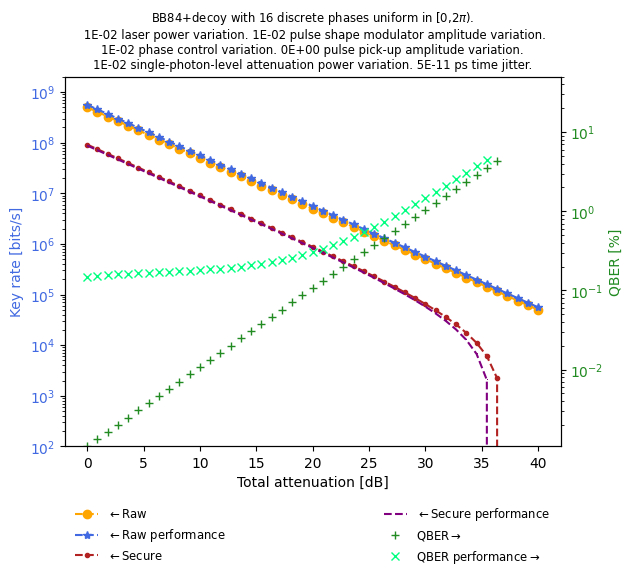

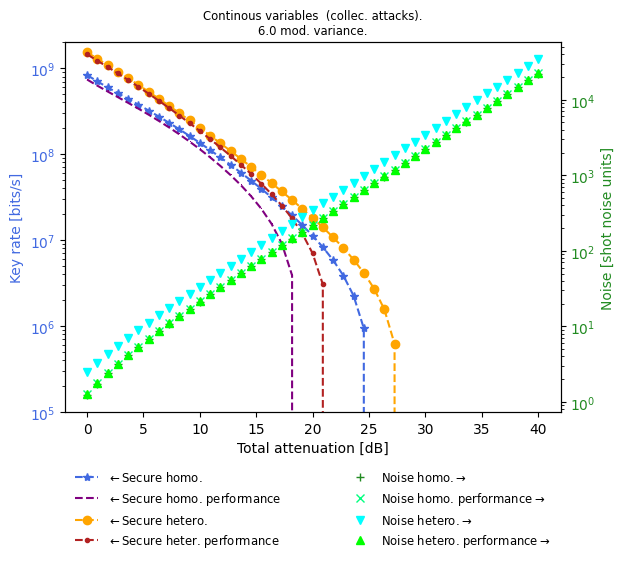

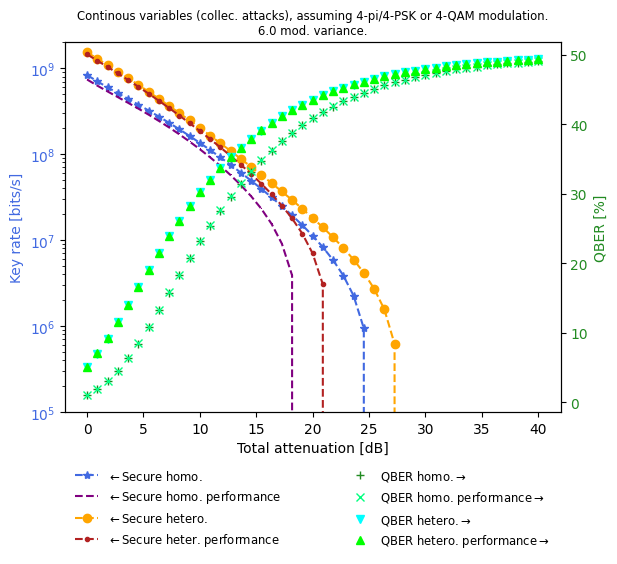

In [4]:
NumDecoyStates=3 # Actually the protocol proposed to be used is Signal+1decoy-state
NumberMeasurementsAlongAttenuationDistance=45
 
AttenuationdBforDistance=np.linspace(0.0,40.0,NumberMeasurementsAlongAttenuationDistance) # Inside, the algorithms account for some internal losses, primarly on the detector side

DecoyStatesRates=np.zeros((NumDecoyStates),dtype=np.float32)
DecoyStatesRates[0]=0.9#0.9
DecoyStatesRates[1]=0.1#0.09
DecoyStatesRates[2]=1.0-DecoyStatesRates[0]-DecoyStatesRates[1]#0.01 # Actually the protocol proposed to be sued is Signal+1decoy-state
DecoyStatesPhotPulse=np.zeros((NumDecoyStates),dtype=np.float32)
DecoyStatesPhotPulse[0]=5e-1
DecoyStatesPhotPulse[1]=1e-2
DecoyStatesPhotPulse[2]=0.0#1e-3# Eventually 0 # Actually the protocol proposed to be used is Signal+1decoy-state
LaserPower=20e-3 # [W]
SourcePulseRate=2e9
OptPulseDuration=0.2*(1.0/SourcePulseRate)#s
Hplank=6.626e-34#J*s
c0=3e8#m/s
n_fiber=1.5
Wavelength=1550e-9#m
EnergySinglePhoton=Hplank*c0/Wavelength
PhotPulse=(OptPulseDuration*LaserPower)/EnergySinglePhoton
SinglePhotonSourceAttdB=10.0*np.log10(PhotPulse/DecoyStatesPhotPulse[0]) # [dB]
############################################################################
######## DV-QKD
###########################################################################
DVQKDprotocol='BB84+decoy'# 'BB84+decoy', 'SARG04+decoy'
# Detector and system performance
SystemDetectorPerformanceArray=np.zeros((6),dtype=np.float32)
SystemDetectorPerformanceArray[0]=1.0e-5# Y0=Detector darkcount rate per detection window time + stray light that falls in the same wavelength window. 1e-5 # Background yield: detector's dark count rate + other background contributions such as stray light from timing pulses
SystemDetectorPerformanceArray[1]=0.5# e0=0.5 # Error rate of background because it is random.
SystemDetectorPerformanceArray[2]=1.0# transmittanceBob=0.5 # linear. Internal attenuation of optical components at Bob's side.
SystemDetectorPerformanceArray[3]=0.5# attDetectors=0.5 # Detectors efficiency at Bob's side.
SystemDetectorPerformanceArray[4]=50e-12# [s] TimeJitterStd=50e-12 - 300e-12 # [s] # Principally from the single photon detectors. It makes qubits fall in different time slots, hence reducing the raw key rate and increasing the background yield
SystemDetectorPerformanceArray[5]=0.1# attenuation link. dB/Km. 0.1: free space; 0.2: fiber

############################# Laser source ##################################
LaserPowerDeviation=1e-2# Power intensity deviation
LaserPowerVariation=1e-2# Power intensity standard deviation
ConfigurationLaserSource=np.zeros((2),dtype=np.float32)
ConfigurationLaserSource[0]=LaserPowerDeviation # Meant for deviation
ConfigurationLaserSource[1]=LaserPowerVariation # Meant for variation
 
############################ Pulse shaping modulator ##########################
PulseShapeAmplitudeDeviation=1e-1 # Intensity deviation
PulseShapeAmplitudeVariation=1e-2 # Intensity standard deviation
ConfigurationPulseShaping=np.zeros((2),dtype=np.float32)
ConfigurationPulseShaping[0]=PulseShapeAmplitudeDeviation # Meant for deviation
ConfigurationPulseShaping[1]=PulseShapeAmplitudeVariation # Meant for standard variation
 
######################### Phase randomization modulator ####################################
Nphases=16 # A good value is 10 or more (typically 16, also max value allowed in the scripts). In the system 4 bits will be used, hence Nphases=16
PhaseRandomizationVariation=1e-2 # Phase randomization standard deviation
ConfigurationPhases=np.zeros((2),dtype=np.float32)
ConfigurationPhases[0]=float(Nphases)
ConfigurationPhases[1]=PhaseRandomizationVariation # rad. Standard deviation/variation
 
############################# Polarization/phase modulator ##################################
PolarizationSelectionAmplitudeDeviation=np.tan(np.pi/100.0)#1e-2 # Deviation from nominal value (potentially it can account for deviations in polarization or phase states)
PolarizationSelectionAmplitudeVariation=0.0#1e-2 # Standard deviation from nominal value
ConfigurationPolarizationSelection=np.zeros((2),dtype=np.float32)
ConfigurationPolarizationSelection[0]=PolarizationSelectionAmplitudeDeviation # Meant for deviation
ConfigurationPolarizationSelection[1]=PolarizationSelectionAmplitudeVariation # Meant for standard variation
 
############################ Attenuation to single-photon level ##########################
SPlevelPowerAttDeviation=1e-2 # Deviation from nominal value
SPlevelPowerAttVariation=1e-2 # Standard variation from nominal value
ConfigurationSPlevelAtt=np.zeros((2),dtype=np.float32)
ConfigurationSPlevelAtt[0]=SPlevelPowerAttDeviation # Meant for deviation
ConfigurationSPlevelAtt[1]=SPlevelPowerAttVariation # Meant for standard variation
 
###############################################################################
# BB84+decoys state Realistic performance taking into account standard variations and deviations
[att,PrecisionElementsRKRDiscretePhase,PrecisionElementsKeyBitRateLowerBondDiscretePhase,PrecisionElementsQBERDiscretePhase]=PrecisionElementsTransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,SinglePhotonSourceAttdB,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,ConfigurationLaserSource,ConfigurationPulseShaping,ConfigurationPhases,ConfigurationPolarizationSelection,ConfigurationSPlevelAtt,SystemDetectorPerformanceArray,DVQKDprotocol)
[att,RKRDiscretePhase,KeyBitRateLowerBondDiscretePhase,QBERDiscretePhase]=TransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,Nphases,SystemDetectorPerformanceArray,DVQKDprotocol)
###############################################################################
 
dBatt=-10*np.log10(att)
 
## Figures
plt.figure()
line1,=plt.plot(dBatt,RKRDiscretePhase,'orange',linestyle='dashed',marker='o')
line2,=plt.plot(dBatt,PrecisionElementsRKRDiscretePhase,'royalblue',linestyle='dashed',marker='*')
line3,=plt.plot(dBatt,KeyBitRateLowerBondDiscretePhase,'firebrick',linestyle='dashed',marker='.')
line4,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondDiscretePhase,'purple',linestyle='dashed',marker=',')
#plt.legend(loc='upper center')
#plt.xscale('log')
plt.ylim(np.max([1e2,KeyBitRateLowerBondDiscretePhase[-1],PrecisionElementsKeyBitRateLowerBondDiscretePhase[-1]]),SourcePulseRate)
plt.yscale('log')
plt.xlabel('Total attenuation [dB]',color='k')
plt.ylabel('Key rate [bits/s]',color='royalblue')
plt.tick_params(axis="y", labelcolor='royalblue')
plt.twinx()
line5,=plt.plot(dBatt,100.0*QBERDiscretePhase,'forestgreen',linestyle='None',marker='+')
line6,=plt.plot(dBatt,100.0*PrecisionElementsQBERDiscretePhase,'springgreen',linestyle='None',marker='x')
plt.yscale('log')
plt.ylim(np.max([5e-4,np.min([100.0*QBERDiscretePhase[0],100.0*PrecisionElementsQBERDiscretePhase[0]])]),5e1)
plt.tick_params(axis="y", labelcolor='forestgreen')
plt.ylabel('QBER [%]', color='forestgreen')
plt.legend((line1, line2, line3, line4, line5, line6), (r'$\leftarrow$'+'Raw',r'$\leftarrow$'+'Raw performance',r'$\leftarrow$'+'Secure',r'$\leftarrow$'+'Secure performance', 'QBER'+r'$\rightarrow$', 'QBER performance'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.35, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.title(DVQKDprotocol+' with '+str(Nphases)+' discrete phases uniform in [$0$,$2\pi$).\n '+str("{:.0E}".format(LaserPowerVariation))+' laser power variation. '+str("{:.0E}".format(PulseShapeAmplitudeVariation))+' pulse shape modulator amplitude variation.\n'+str("{:.0E}".format(PhaseRandomizationVariation))+' phase control variation. '+str("{:.0E}".format(PolarizationSelectionAmplitudeVariation))+' pulse pick-up amplitude variation.\n'+str("{:.0E}".format(SPlevelPowerAttVariation))+' single-photon-level attenuation power variation. '+str("{:.0E}".format(SystemDetectorPerformanceArray[4]))+r' ps'+' time jitter.', fontsize='small')
plt.savefig('FigTheoreticalBB84decoySKRqber.png', format = 'png', dpi = 600 )
plt.show()
################################################################################
## BB84+decoys state Model system/protocol without taking into account variations and deviations
#[att,RKRContinuousPhase,KeyBitRateLowerBondContinuousPhase,QBERContinuousPhase]=TransmissionBB84DecoyStateComputeSKRcontinuousphase.TransmissionBB84DecoyStateComputeSKRcontinuousphase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,SystemDetectorPerformanceArray,DVQKDprotocol)
#[att,RKRDiscretePhase,KeyBitRateLowerBondDiscretePhase,QBERDiscretePhase]=TransmissionBB84DecoyStateComputeSKRdiscretephase.TransmissionBB84DecoyStateComputeSKRdiscretephase(SourcePulseRate,DecoyStatesRates,DecoyStatesPhotPulse,AttenuationdBforDistance,Nphases,SystemDetectorPerformanceArray,DVQKDprotocol)
################################################################################
#
#dBatt=-10*np.log10(att)
# 
## Figures
#plt.figure()
#line1,=plt.plot(dBatt,RKRContinuousPhase,'orange',linestyle='dashed',marker='o')
#line2,=plt.plot(dBatt,RKRDiscretePhase,'royalblue',linestyle='dashed',marker='*')
#line3,=plt.plot(dBatt,KeyBitRateLowerBondContinuousPhase,'firebrick',linestyle='dashed',marker='.')
#line4,=plt.plot(dBatt,KeyBitRateLowerBondDiscretePhase,'purple',linestyle='dashed',marker=',')
##plt.legend(loc='upper center')
##plt.xscale('log')
#plt.ylim(np.max([1e2,KeyBitRateLowerBondContinuousPhase[-1]]),SourcePulseRate)
#plt.yscale('log')
#plt.xlabel('Total attenuation [dB]',color='k')
#plt.ylabel('Key rate [bits/s]',color='royalblue')
#plt.tick_params(axis="y", labelcolor='royalblue')
#plt.twinx()
#line5,=plt.plot(dBatt,100.0*QBERContinuousPhase,'forestgreen',linestyle='None',marker='+')
#line6,=plt.plot(dBatt,100.0*QBERDiscretePhase,'springgreen',linestyle='None',marker='x')
#plt.yscale('log')
#plt.ylim(np.max([5e-4,np.min([100.0*QBERContinuousPhase[0],100.0*QBERDiscretePhase[0]])]),5e1)
#plt.tick_params(axis="y", labelcolor='forestgreen')
#plt.ylabel('QBER [%]', color='forestgreen')
#plt.legend((line1, line2, line3, line4, line5, line6), (r'$\leftarrow$'+'Raw (continuous phase)',r'$\leftarrow$'+'Raw (discrete phase)',r'$\leftarrow$'+'Secure (continuous phase)',r'$\leftarrow$'+'Secure (discrete phase)', 'QBER (continuous phase)'+r'$\rightarrow$','QBER (discrete phase)'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.5, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
#plt.title(DVQKDprotocol+' N discrete phases uniform in [$0$,$2\pi$), N = '+str(Nphases), fontsize='small')
#plt.show()

###############################################################################
# Continuous variables
##############################################################################
############################################################################
# Detector and system performance
SystemDetectorPerformanceArray=np.zeros((27),dtype=np.float32)
SystemDetectorPerformanceArray[0]=6.0 # modulation variance >1.0. It is important to optimize this value. Experimental study on discretely modulated continuous-variable quantum key distribution
SystemDetectorPerformanceArray[1]=0.5# transmittanceBob # linear. Internal attenuation of optical components at Bob's side (at least the homodyne detection beamsplitter). At least de beamsplitter for homodyne/heterodyne
SystemDetectorPerformanceArray[2]=0.9# Detectors efficiency at Bob's side
SystemDetectorPerformanceArray[3]=8e-15 # Relative intensity noise of the signal laser [Hz**-1]
SystemDetectorPerformanceArray[4]=SourcePulseRate
SystemDetectorPerformanceArray[5]=1.4e-12 # Relative intensity noise of the local oscilator [Hz**-1]
SystemDetectorPerformanceArray[6]=1e-8 # Variance of quadratures without taking the local oscillators's RIN into account [V**2]
SystemDetectorPerformanceArray[7]=1.0 # Electric gain driving the modulators [V]
SystemDetectorPerformanceArray[8]=0.85 #Responsitivity of the PIN diodes [A/W]
SystemDetectorPerformanceArray[9]=0.01 # Relative voltage deviation of the DAC
SystemDetectorPerformanceArray[10]=1.5 # Upi: voltage required to achieve a phase rotation of π
SystemDetectorPerformanceArray[11]=SystemDetectorPerformanceArray[10]/SystemDetectorPerformanceArray[7] # UDAC=Upi/g
SystemDetectorPerformanceArray[12]=5.0 #Variance of the pilot tone [SNU]. Has to be higher or equal than 1.0. Directly related to phase noise, in particular in local local oscilaltor
SystemDetectorPerformanceArray[13]=8.0 # It is common to sample several, say N pilot-tone measurements
SystemDetectorPerformanceArray[14]=600.0 # Variance of the pilot tone [SNU], related to the mean photon number. Has to be higher or equal than 1.0. The higher the better.
SystemDetectorPerformanceArray[15]=8e-12 #Spectral filter bandwidth [m]
SystemDetectorPerformanceArray[16]=-75.0 # Spectral Raman noise density [dBm/nm]
SystemDetectorPerformanceArray[17]=OptPulseDuration # Pulse duration [s]
SystemDetectorPerformanceArray[18]=c0/(n_fiber*Wavelength) #Optical frequency [Hz]
SystemDetectorPerformanceArray[19]=10000.0 # Common-mode rejection ratio homodyne
SystemDetectorPerformanceArray[20]=1e-2 # local oscillator power [W]. Up to some point the higher the better
SystemDetectorPerformanceArray[21]=4.5e-18 # Noise equivalent power of the detector. Key factor for high speed transmissions
SystemDetectorPerformanceArray[22]=10.0 # Bit resolution of the ADC
SystemDetectorPerformanceArray[23]=1.0 # Dynamic voltage range of the ADC [V]
SystemDetectorPerformanceArray[24]=1e-8 # Intrinsic voltage variance of the ADC [V**2]
SystemDetectorPerformanceArray[25]=20e3# Electric amplification for detector ADC [Ohms]
SystemDetectorPerformanceArray[26]=0.2# Link attenuation. dB/Km. 0.1: free space; 0.2: fiber

AttenuationdBforDistance=np.linspace(0.0,40.0,NumberMeasurementsAlongAttenuationDistance) # Inside, the algorithms account for some internal losses, primarly on the detector side

# Continous variables Realistic performance taking into account variations and deviations
[att,PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne,PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne,PrecisionElementsNoiseContinousVariablesHomodyne,PrecisionElementsNoiseContinousVariablesHeterodyne,PrecisionElementsQBERHomodyneContinousVariables,PrecisionElementsQBERHeterodyneContinousVariables]=PrecisionElementsTransmissionContinousVariablesComputeSKR(SourcePulseRate,SinglePhotonSourceAttdB,AttenuationdBforDistance,SystemDetectorPerformanceArray)
[att,KeyBitRateLowerBondContinousVariablesHomoDyne,KeyBitRateLowerBondContinousVariablesHeteroDyne,NoiseContinousVariablesHomodyne,NoiseContinousVariablesHeterodyne,QBERHomodyneContinousVariables,QBERHeterodyneContinousVariables]=TransmissionContinuousVariablesComputeSKR(SourcePulseRate,AttenuationdBforDistance,SystemDetectorPerformanceArray)
###############################################################################
 
dBatt=-10*np.log10(att)

## Figures
plt.figure()
line1,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHomoDyne,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHeteroDyne,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne,'firebrick',linestyle='dashed',marker='.')
#plt.legend(loc='upper center')
#plt.xscale('log')
plt.yscale('log')
plt.ylim(np.max([1e5,KeyBitRateLowerBondContinousVariablesHomoDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne[-1],KeyBitRateLowerBondContinousVariablesHeteroDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne[-1]]),SourcePulseRate)
plt.xlabel('Total attenuation [dB]',color='k')
plt.ylabel('Key rate [bits/s]',color='royalblue')
plt.tick_params(axis="y", labelcolor='royalblue')
plt.twinx()
line5,=plt.plot(dBatt,NoiseContinousVariablesHomodyne,'forestgreen',linestyle='None',marker='+')
line6,=plt.plot(dBatt,PrecisionElementsNoiseContinousVariablesHomodyne,'springgreen',linestyle='None',marker='x')
line7,=plt.plot(dBatt,NoiseContinousVariablesHeterodyne,'cyan',linestyle='None',marker='v')
line8,=plt.plot(dBatt,PrecisionElementsNoiseContinousVariablesHeterodyne,'lime',linestyle='None',marker='^')
plt.yscale('log')
#plt.ylim(np.max([5e-4,np.min([100.0*NoiseContinousVariables[0],100.0*PrecisionElementsNoiseContinousVariables[0]])]),1e2)
plt.tick_params(axis="y", labelcolor='forestgreen')
plt.ylabel('Noise [shot noise units]', color='forestgreen')
plt.legend((line1, line2, line3, line4, line5, line6, line7, line8), (r'$\leftarrow$'+'Secure homo.',r'$\leftarrow$'+'Secure homo. performance',r'$\leftarrow$'+'Secure hetero.',r'$\leftarrow$'+'Secure heter. performance', 'Noise homo.'+r'$\rightarrow$', 'Noise homo. performance'+r'$\rightarrow$', 'Noise hetero.'+r'$\rightarrow$', 'Noise hetero. performance'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.4, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.title('Continous variables  (collec. attacks).\n'+str("{:.1f}".format(SystemDetectorPerformanceArray[0]))+' mod. variance.', fontsize='small')
#plt.savefig('FigTheoreticalCVSKRnoise.png', format = 'png', dpi = 600 )
plt.show()

## Figures
plt.figure()
line1,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHomoDyne,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(dBatt,KeyBitRateLowerBondContinousVariablesHeteroDyne,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(dBatt,PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne,'firebrick',linestyle='dashed',marker='.')
#plt.legend(loc='upper center')
#plt.xscale('log')
plt.yscale('log')
plt.ylim(np.max([1e5,KeyBitRateLowerBondContinousVariablesHomoDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHomoDyne[-1],KeyBitRateLowerBondContinousVariablesHeteroDyne[-1],PrecisionElementsKeyBitRateLowerBondContinousVariablesHeteroDyne[-1]]),SourcePulseRate)
plt.xlabel('Total attenuation [dB]',color='k')
plt.ylabel('Key rate [bits/s]',color='royalblue')
plt.tick_params(axis="y", labelcolor='royalblue')
plt.twinx()
line5,=plt.plot(dBatt,100.0*QBERHomodyneContinousVariables,'forestgreen',linestyle='None',marker='+')
line6,=plt.plot(dBatt,100.0*PrecisionElementsQBERHomodyneContinousVariables,'springgreen',linestyle='None',marker='x')
line7,=plt.plot(dBatt,100.0*QBERHeterodyneContinousVariables,'cyan',linestyle='None',marker='v')
line8,=plt.plot(dBatt,100.0*PrecisionElementsQBERHeterodyneContinousVariables,'lime',linestyle='None',marker='^')
#plt.yscale('log')
#plt.ylim(np.max([5e-4,np.min([100.0*PrecisionElementsQBERHomodyneContinousVariables[0],100.0*PrecisionElementsQBERHeterodyneContinousVariables[0],100.0*QBERHomodyneContinousVariables[0],100.0*QBERHeterodyneContinousVariables[0]])]),5e1)
plt.tick_params(axis="y", labelcolor='forestgreen')
plt.ylabel('QBER [%]', color='forestgreen')
plt.legend((line1, line2, line3, line4, line5, line6, line7, line8), (r'$\leftarrow$'+'Secure homo.',r'$\leftarrow$'+'Secure homo. performance',r'$\leftarrow$'+'Secure hetero.',r'$\leftarrow$'+'Secure heter. performance', 'QBER homo.'+r'$\rightarrow$', 'QBER homo. performance'+r'$\rightarrow$', 'QBER hetero.'+r'$\rightarrow$', 'QBER hetero. performance'+r'$\rightarrow$'),bbox_to_anchor=(0, -0.4, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.title('Continous variables (collec. attacks), assuming 4-pi/4-PSK or 4-QAM modulation.\n'+str("{:.1f}".format(SystemDetectorPerformanceArray[0]))+' mod. variance.', fontsize='small')
#plt.savefig('FigTheoreticalCVSKRqber.png', format = 'png', dpi = 600 )
plt.show()